<a href="https://colab.research.google.com/github/BlueBlazin/nlp_from_ground_up/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

First, some basic functions.

In [ ]:
def softmax(x, temp=1.0):
    x -= np.max(x)
    x = np.exp(x / temp)
    return x / np.sum(x)

In [ ]:
def cross_entropy(t, pred):
    target = np.zeros_like(pred)
    target[t] = 1
    return -np.sum(target * np.log(pred))

In [ ]:
def loss_fn(ts, ys):
    return sum(cross_entropy(t, y) for t, y in zip(ts, ys)) / len(ts)

The vanilla RNN is just $\mathbf{h_t} = \text{tanh}(\mathbf{W_x} \mathbf{x_t} + \mathbf{W_h} \mathbf{h_{t-1}} + \mathbf{b_h})$.

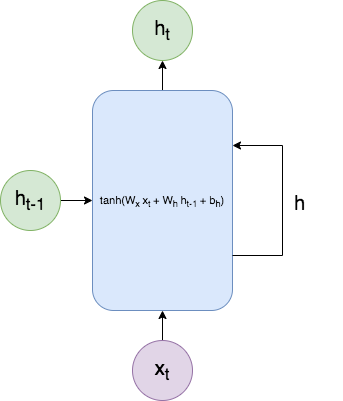

In [ ]:
def rnn_cell(x, hprev, Wx, Wh, bh):
    return np.tanh(Wx @ x + Wh @ hprev + bh)

In [ ]:
def forward_pass(xs, h, Wx, Wh, bh, Wy, by):
    hs = []
    ys = []

    for x in xs:
        h = rnn_cell(x, h, Wx, Wh, bh)
        hs.append(h)

        y = softmax(Wy @ h + by)
        ys.append(y)

    return ys, hs

#### Backward Pass

When it comes to writing backpropagation by hand it's helpful to be explicit by drawing the computation graph in steps of simple operations.

Note: If the emphasis is on simple operations, why the `cross_ent(softmax(r_t))` step? That's because that entire operation has a very simple gradient (explained below).

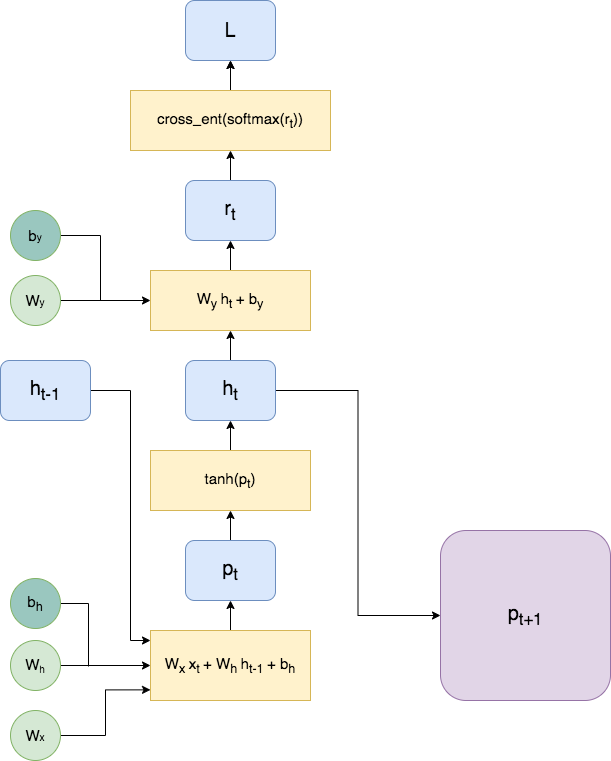

In [ ]:
def backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh):
    dWy = np.zeros_like(Wy)
    dby = np.zeros_like(by)

    dWx = np.zeros_like(Wx)

    dWh = np.zeros_like(Wh)
    dbh = np.zeros_like(bh)

    dpnext = np.zeros_like(hs[0])

    for t in reversed(range(len(ys))):
        y = ys[t]
        h = hs[t]
        x = xs[t]
        hprev = hs[t - 1]

        dr = y.copy()
        dr[ts[t]] -= 1

        dh = Wy.T @ dr + Wh @ dpnext

        dWy += dr @ h.T
        dby += dr

        dp = (1 - h * h) * dh

        dWx += dp @ x.T

        dWh += dp @ hprev.T
        dbh += dp

        dpnext = dp.copy()

    return dWy, dby, dWx, dWh, dbh

In [ ]:
xs = [np.array([[1, 0, 0, 0]]).T, np.array([[0, 1, 0, 0]]).T, np.array([[0, 0, 1, 0]]).T]

ts = [1, 2, 3]

Wx = np.random.randn(3, 4)

Wh = np.random.randn(3, 3)
bh = np.random.randn(3, 1)

Wy = np.random.randn(4, 3)
by = np.random.randn(4, 1)

hzero = np.zeros((3, 1))

In [ ]:
alpha = 0.01
losses = []

for i in range(5000):
    ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
    hs.append(hzero)

    losses.append(loss_fn(ts, ys))

    if i % 500 == 0:
        print(losses[-1])

    dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

    Wy -= alpha * dWy
    by -= alpha * dby

    Wx -= alpha * dWx

    Wh -= alpha * dWh
    bh -= alpha * dbh

In [ ]:
df = pd.DataFrame({'Epoch': range(len(losses)), 'Loss': losses})
fig = px.line(df, x="Epoch", y="Loss", title='Training loss')
fig.show()

In [ ]:
import tensorflow_datasets as tfds

dataset = tfds.load(name='tiny_shakespeare')['train']

dataset = next(iter(dataset))['text'].numpy()
dataset = dataset.split(b"\n")
dataset = map(list, dataset)
dataset = filter(lambda x: len(x) >= 2, dataset)

In [ ]:
hidden_dim = 128
vocab_size = 258  # 255 ascii chars + 2 special tokens
seq_length = 25
alpha = 0.001
num_epochs = 1
mu = 0.5
START = 256
END = 257

In [ ]:
def one_hot(k):
    enc = np.zeros((vocab_size, 1))
    enc[k, 0] = 1
    return enc

In [ ]:
def xavier(shape):
    width = 1 / np.sqrt(shape[-1])
    return np.random.uniform(-width, width, size=shape)

In [ ]:
Wx = xavier((hidden_dim, vocab_size))

Wh = xavier((hidden_dim, hidden_dim))
bh = xavier((hidden_dim, 1))

Wy = xavier((vocab_size, hidden_dim))
by = xavier((vocab_size, 1))

In [ ]:
v_Wx = np.zeros_like(Wx)

v_Wh = np.zeros_like(Wh)
v_bh = np.zeros_like(bh)

v_Wy = np.zeros_like(Wy)
v_by = np.zeros_like(by)

In [ ]:
i = 0
losses = []

for epoch in range(num_epochs):
    step = 0

    for line in dataset:
        hzero = np.zeros_like(bh)

        width = min(seq_length, len(line) + 1)  # plus one to account for START

        line = [START] + line + [END]

        for t in range(0, width, width):
            raw = line[t:t + width + 1]

            xs = raw[:-1]
            xs = [one_hot(k) for k in xs]

            ts = raw[1:]

            ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
            hs.append(hzero)

            if step % 500 == 0:
                losses.append(loss_fn(ts, ys))
                print(f"Loss on epoch {epoch}, step: {step}: {losses[-1]}")

            dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

            v_Wy = mu * v_Wy - alpha * dWy
            Wy += v_Wy

            v_by = mu * v_by - alpha * dby
            by += v_by

            v_Wx = mu * v_Wx - alpha * dWx
            Wx += v_Wx

            v_Wh = mu * v_Wh - alpha * dWh
            Wh += v_Wh

            v_bh = mu * v_bh - alpha * dbh
            bh += v_bh

            hzero = hs[-2]  # the last h_t will be the next hzero
            step += 1

In [ ]:
df = pd.DataFrame({'Epoch': range(len(losses)),
                   'Loss': losses,
                   'Running Avg Loss': np.convolve(losses, np.ones(10)/10, mode='valid')})

fig = px.line(df, x="Step", y="Loss")
fig = px.line(df, x="Step", y="Running Avg Loss")
fig.show()

In [ ]:
h = np.zeros_like(bh)
sentence = ['T']
x = ord(sentence[0])

for _ in range(140):
    h = rnn_cell(one_hot(x), h, Wx, Wh, bh)
    y = softmax(Wy @ h + by)

    x = np.random.choice(range(vocab_size), p=y[:, 0])
    sentence.append(chr(x))

print("".join(sentence))